In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.special import gammaln # for log(n!) = gammaln(n+1)
import ROOT
from array import array


In [2]:
# Define Gaussian for Signal

# Your model functions
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def exponential(x, B, l):
    return B * np.exp(-(l * x))

def splusb_model(x, A, mu, sigma, B, l):
    return gaussian(x, A, mu, sigma) + exponential(x, B, l)

def profile_likelihood_ratio_mu0(counts, expected_splusb, expected_bonly):
    eps = 1e-10
    counts = np.asarray(counts) ### This line converts the counts object (which comes from uproot) into a NumPy array.
    nu_splusb = np.clip(expected_splusb, eps, None)
    nu_bonly = np.clip(expected_bonly, eps, None)

    logL_splusb = np.sum(counts * np.log(nu_splusb) - nu_splusb - gammaln(counts + 1))
    logL_bonly = np.sum(counts * np.log(nu_bonly) - nu_bonly - gammaln(counts + 1))

    q0 = 2 * (logL_splusb - logL_bonly)

    return q0



def printValues(params_splusb, params_bonly, bin_centers, counts ):
    # Unpack S+B parameters
    A, mu, sigma, B_splusb, l_splusb = params_splusb

    # Unpack B-only parameters
    B_bonly, l_bonly = params_bonly

    # Compute expected values from models
    signal_expected = gaussian(bin_centers, A, mu, sigma)
    background_expected_splusb = exponential(bin_centers, B_splusb, l_splusb)
    background_expected_bonly = exponential(bin_centers, B_bonly, l_bonly)

    # Total expected from S+B
    total_expected_splusb = signal_expected + background_expected_splusb


    splusb = 0
    b = 0
    n = 0
    bonly = 0
    
    # Print per-bin results
    for i in range(len(bin_centers)):
        print(f"Bin {i+1}:")
        print(f"  Bin center       = {bin_centers[i]:.2f}")
        print(f"  Observed count   = {counts[i]:.2f}")
        print(f"  Signal (S)       = {signal_expected[i]:.2f}")
        print(f"  Background (B)   = {background_expected_splusb[i]:.2f}")
        print(f"  S+B (expected)   = {total_expected_splusb[i]:.2f}")
        print(f"  B-only expected  = {background_expected_bonly[i]:.2f}")
   

        print()
        splusb = splusb + total_expected_splusb[i]
        b = b + background_expected_bonly[i]
        n = n + counts[i]
        bonly = bonly + background_expected_bonly[i]
        
    print(f"total splusb {splusb}; bonly {bonly} and observed {n}")
    


In [3]:
# # Load ROOT file

# fname = "Bonly_3000.root"
# #fname = "SplusB_1000.root"
# file = uproot.open(fname)

# # Histogram binning (should match generation)
# nbins = 100
# xmin, xmax = 0, 10
# bin_edges = np.linspace(xmin, xmax, nbins+1)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# q0_values = []

# # Loop over all histograms
# for i in range(3000):
#     hist_name = f"SplusB_hist_{i}"
#     if hist_name not in file:
#         print(f"Missing histogram: {hist_name}")
#         continue

#     hist = file[hist_name]
#     counts = hist.values()

#     try:
#         # Fit S+B
#         p0_splusb = [np.max(counts)/100, 5, 1, 99*np.max(counts)/100, -0.3]
#         popt, pcov = curve_fit(splusb_model, bin_centers, counts, p0=p0_splusb,
#                                sigma=np.sqrt(counts), absolute_sigma=True, maxfev=150000)

#         expected_splusb = splusb_model(bin_centers, *popt)
#         expected_splusb = np.clip(expected_splusb, 1e-9, None)  # Avoid log(0)

#         # Fit B-only
#         p0_bonly = [np.max(counts), -0.3]
#         popt_bonly, pcov_bonly = curve_fit(exponential, bin_centers, counts, p0=p0_bonly,
#                                            sigma=np.sqrt(counts), absolute_sigma=True, maxfev=150000)

#         expected_bonly = exponential(bin_centers, *popt_bonly)
#         expected_bonly = np.clip(expected_bonly, 1e-9, None)  # Avoid log(0)

#         # Calculate -2 * log-likelihood ratio test statistic q0
#         # Using Poisson log-likelihood approximation
#         logL_bonly = np.sum(counts * np.log(expected_bonly) - expected_bonly)
#         logL_splusb = np.sum(counts * np.log(expected_splusb) - expected_splusb)
#         q0 = -2 * (logL_bonly - logL_splusb)

#         q0_values.append(q0)


#         if i == 0:
#         # import matplotlib.pyplot as plt

#             plt.figure(figsize=(8, 6))
#             plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label='Data', color='black')
#             plt.plot(bin_centers, expected_bonly, label='B-only Fit', color='red', linestyle='--')
#             plt.plot(bin_centers, expected_splusb, label='S+B Fit', color='blue')
#             plt.title(f"Fit Comparison: {hist_name}")
#             plt.xlabel("Bin Center")
#             plt.ylabel("Counts")
#             plt.legend()
#             plt.grid(True)
#             plt.tight_layout()
#             plt.show()


#     except RuntimeError as e:
#         print(f"Fit failed for {hist_name}: {e}")
#         continue
#     except Exception as e:
#         print(f"Unexpected error in {hist_name}: {e}")
#         continue

        
        
       




In [4]:
# # Load ROOT file
# fname = "Bonly_3000.root"
# file = uproot.open(fname)

# # Histogram binning
# nbins = 100
# xmin, xmax = 0, 10
# bin_edges = np.linspace(xmin, xmax, nbins + 1)
# bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# # List for storing test statistics
# q0_values = []

# # Create output ROOT file
# out_rootfile = ROOT.TFile("fit_results.root", "RECREATE")

# # Loop over all histograms
# for i in range(3000):
#     hist_name = f"SplusB_hist_{i}"
#     if hist_name not in file:
#         print(f"Missing histogram: {hist_name}")
#         continue

#     hist = file[hist_name]
#     counts = hist.values()

#     try:
#         # Initial guesses
#         p0_splusb = [np.max(counts)/100, 5, 1, 99*np.max(counts)/100, -0.3]
#         p0_bonly = [np.max(counts), -0.3]

#         # Fit S+B model
#         popt, pcov = curve_fit(splusb_model, bin_centers, counts, p0=p0_splusb,
#                                sigma=np.sqrt(counts), absolute_sigma=True, maxfev=150000)
#         expected_splusb = splusb_model(bin_centers, *popt)
#         expected_splusb = np.clip(expected_splusb, 1e-9, None)

#         # Fit B-only model
#         popt_bonly, pcov_bonly = curve_fit(exponential, bin_centers, counts, p0=p0_bonly,
#                                            sigma=np.sqrt(counts), absolute_sigma=True, maxfev=150000)
#         expected_bonly = exponential(bin_centers, *popt_bonly)
#         expected_bonly = np.clip(expected_bonly, 1e-9, None)

#         # Calculate -2 log-likelihood ratio
#         logL_bonly = np.sum(counts * np.log(expected_bonly) - expected_bonly)
#         logL_splusb = np.sum(counts * np.log(expected_splusb) - expected_splusb)
#         q0 = -2 * (logL_bonly - logL_splusb)
#         q0_values.append(q0)

#         # Plot i=0 histogram with fits
#         # if i == 0:
#         #     plt.figure(figsize=(8, 6))
#         #     plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', label='Data', color='black')
#         #     plt.plot(bin_centers, expected_bonly, label='B-only Fit', color='red', linestyle='--')
#         #     plt.plot(bin_centers, expected_splusb, label='S+B Fit', color='blue')
#         #     plt.title(f"Fit Comparison: {hist_name}")
#         #     plt.xlabel("Bin Center")
#         #     plt.ylabel("Counts")
#         #     plt.legend()
#         #     plt.grid(True)
#         #     plt.tight_layout()
#         #     plt.show()

#         # Save histogram to ROOT
#         hist_TH1 = ROOT.TH1F(hist_name, hist_name, nbins, array('d', bin_edges))
#         for j in range(nbins):
#             hist_TH1.SetBinContent(j + 1, counts[j])
#             hist_TH1.SetBinError(j + 1, np.sqrt(counts[j]))
#         hist_TH1.Write()

#         # Save fit curves as TGraph
#         gr_splusb = ROOT.TGraph(nbins, array('d', bin_centers), array('d', expected_splusb))
#         gr_splusb.SetName(f"{hist_name}_SplusB_fit")
#         gr_splusb.Write()

#         gr_bonly = ROOT.TGraph(nbins, array('d', bin_centers), array('d', expected_bonly))
#         gr_bonly.SetName(f"{hist_name}_Bonly_fit")
#         gr_bonly.Write()

#     except RuntimeError as e:
#         print(f"Fit failed for {hist_name}: {e}")
#         continue
#     except Exception as e:
#         print(f"Unexpected error in {hist_name}: {e}")
#         continue

# # Save q0 values histogram
# if len(q0_values) > 0:
#     h_q0 = ROOT.TH1F("q0_distribution", "-2log(L_b/L_sb)", 100,
#                      min(q0_values), max(q0_values))
#     for val in q0_values:
#         h_q0.Fill(val)
#     h_q0.Write()

# # Close output ROOT file
# out_rootfile.Close()

# print("✅ Fit results and histograms saved to fit_results.root")


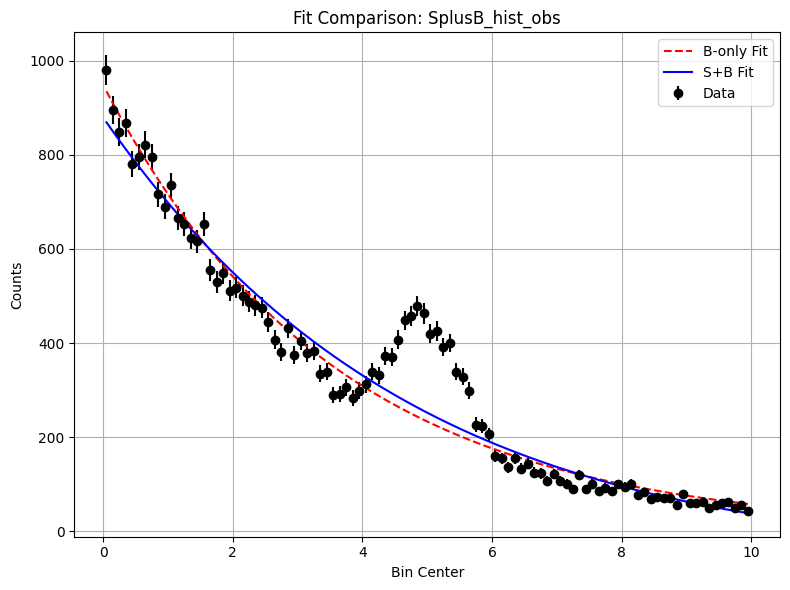

Fit failed for SplusB_hist_29: Optimal parameters not found: Number of calls to function has reached maxfev = 150000.


/tmp/ipykernel_11611/125110030.py:77: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(splusb_model, bin_centers, counts, p0=p0_splusb,


Fit failed for SplusB_hist_392: Optimal parameters not found: Number of calls to function has reached maxfev = 150000.
Fit failed for SplusB_hist_418: Optimal parameters not found: Number of calls to function has reached maxfev = 150000.
Fit failed for SplusB_hist_484: Optimal parameters not found: Number of calls to function has reached maxfev = 150000.


/tmp/ipykernel_11611/1395769576.py:8: RuntimeWarning: overflow encountered in exp
  return B * np.exp(-(l * x))


Fit failed for SplusB_hist_798: Optimal parameters not found: Number of calls to function has reached maxfev = 150000.
Fit failed for SplusB_hist_875: Optimal parameters not found: Number of calls to function has reached maxfev = 150000.
Fit failed for SplusB_hist_1277: Optimal parameters not found: Number of calls to function has reached maxfev = 150000.
Fit failed for SplusB_hist_1374: Optimal parameters not found: Number of calls to function has reached maxfev = 150000.
Fit failed for SplusB_hist_2164: Optimal parameters not found: Number of calls to function has reached maxfev = 150000.
Fit failed for SplusB_hist_2212: Optimal parameters not found: Number of calls to function has reached maxfev = 150000.
Fit failed for SplusB_hist_2292: Optimal parameters not found: Number of calls to function has reached maxfev = 150000.
Fit failed for SplusB_hist_2860: Optimal parameters not found: Number of calls to function has reached maxfev = 150000.
✅ Fit results and canvases saved to fit_re

In [5]:
# Load ROOT file
fname = "Bonly_3000.root"
file = uproot.open(fname)

# Histogram binning
nbins = 100
xmin, xmax = 0, 10
bin_edges = np.linspace(xmin, xmax, nbins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# List for storing test statistics
q0_values = []

# Create output ROOT file
out_rootfile = ROOT.TFile("fit_results.root", "RECREATE")

hist_name_obs = f"SplusB_hist_obs"

hist_obs = file[hist_name_obs]
counts_obs = hist_obs.values()

p0_splusb_obs = [np.max(counts_obs)/100, 5, 1, 99*np.max(counts_obs)/100, -0.3]
p0_bonly_obs = [np.max(counts_obs), -0.3]

# Fit S+B model
popt_obs, pcov_obs = curve_fit(splusb_model, bin_centers, counts_obs, p0=p0_splusb_obs,
                        sigma=np.sqrt(counts_obs), absolute_sigma=True, maxfev=150000)
expected_splusb_obs = splusb_model(bin_centers, *popt_obs)
expected_splusb_obs = np.clip(expected_splusb_obs, 1e-9, None)

# Fit B-only model
popt_bonly_obs, pcov_bonly_obs = curve_fit(exponential, bin_centers, counts_obs, p0=p0_bonly_obs,
                                    sigma=np.sqrt(counts_obs), absolute_sigma=True, maxfev=150000)
expected_bonly_obs = exponential(bin_centers, *popt_bonly_obs)
expected_bonly_obs = np.clip(expected_bonly_obs, 1e-9, None)



# Compute likelihood ratio
# logL_bonly = np.sum(counts * np.log(expected_bonly) - expected_bonly)
# logL_splusb = np.sum(counts * np.log(expected_splusb) - expected_splusb)
# q0 = -2 * (logL_bonly - logL_splusb)
# q0_values.append(q0)

q0_obs = profile_likelihood_ratio_mu0(counts_obs, expected_splusb_obs, expected_bonly_obs)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_centers, counts_obs, yerr=np.sqrt(counts_obs), fmt='o', label='Data', color='black')
plt.plot(bin_centers, expected_bonly_obs, label='B-only Fit', color='red', linestyle='--')
plt.plot(bin_centers, expected_splusb_obs, label='S+B Fit', color='blue')
plt.title(f"Fit Comparison: {hist_name_obs}")
plt.xlabel("Bin Center")
plt.ylabel("Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Loop over all histograms
for i in range(3000):
    hist_name = f"SplusB_hist_{i}"
    if hist_name not in file:
        print(f"Missing histogram: {hist_name}")
        continue

    hist = file[hist_name]
    counts = hist.values()

    try:
        # Initial parameter guesses
        p0_splusb = [np.max(counts)/100, 5, 1, 99*np.max(counts)/100, -0.3]
        p0_bonly = [np.max(counts), -0.3]

        # Fit S+B model
        popt, pcov = curve_fit(splusb_model, bin_centers, counts, p0=p0_splusb,
                               sigma=np.sqrt(counts), absolute_sigma=True, maxfev=150000)
        expected_splusb = splusb_model(bin_centers, *popt)
        expected_splusb = np.clip(expected_splusb, 1e-9, None)

        # Fit B-only model
        popt_bonly, pcov_bonly = curve_fit(exponential, bin_centers, counts, p0=p0_bonly,
                                           sigma=np.sqrt(counts), absolute_sigma=True, maxfev=150000)
        expected_bonly = exponential(bin_centers, *popt_bonly)
        expected_bonly = np.clip(expected_bonly, 1e-9, None)



        # Compute likelihood ratio
        # logL_bonly = np.sum(counts * np.log(expected_bonly) - expected_bonly)
        # logL_splusb = np.sum(counts * np.log(expected_splusb) - expected_splusb)
        # q0 = -2 * (logL_bonly - logL_splusb)
        # q0_values.append(q0)

        q0 = profile_likelihood_ratio_mu0(counts, expected_splusb, expected_bonly)
        q0_values.append(q0)

        # --------------------
        # ROOT histogram setup
        # --------------------
        hist_TH1 = ROOT.TH1F(hist_name, hist_name, nbins, array('d', bin_edges))
        for j in range(nbins):
            hist_TH1.SetBinContent(j + 1, counts[j])
            hist_TH1.SetBinError(j + 1, np.sqrt(counts[j]))

        # TGraphs for fitted functions
        gr_splusb = ROOT.TGraph(nbins, array('d', bin_centers), array('d', expected_splusb))
        gr_splusb.SetLineColor(ROOT.kBlue)
        gr_splusb.SetLineWidth(2)
        gr_splusb.SetName(f"{hist_name}_SplusB_fit")

        gr_bonly = ROOT.TGraph(nbins, array('d', bin_centers), array('d', expected_bonly))
        gr_bonly.SetLineColor(ROOT.kRed)
        gr_bonly.SetLineStyle(2)
        gr_bonly.SetLineWidth(2)
        gr_bonly.SetName(f"{hist_name}_Bonly_fit")

        # Create and draw canvas
        canvas = ROOT.TCanvas(f"canvas_{hist_name}", f"Fit Canvas - {hist_name}", 800, 600)
        hist_TH1.Draw("E")
        gr_splusb.Draw("L SAME")
        gr_bonly.Draw("L SAME")

        # Add legend
        legend = ROOT.TLegend(0.6, 0.7, 0.88, 0.88)
        legend.AddEntry(hist_TH1, "Data", "lep")
        legend.AddEntry(gr_splusb, "S+B Fit", "l")
        legend.AddEntry(gr_bonly, "B-only Fit", "l")
        legend.Draw()

        # Write everything
        hist_TH1.Write()
        gr_splusb.Write()
        gr_bonly.Write()
        canvas.Write()

    except RuntimeError as e:
        print(f"Fit failed for {hist_name}: {e}")
        continue
    except Exception as e:
        print(f"Unexpected error in {hist_name}: {e}")
        continue

# Save q0 distribution
if len(q0_values) > 0:
    h_q0 = ROOT.TH1F("q0_distribution", "-2log(L_b/L_sb)", 100,
                     min(q0_values), max(q0_values))
    for val in q0_values:
        h_q0.Fill(val)
    h_q0.Write()

# Close output file
out_rootfile.Close()
print("✅ Fit results and canvases saved to fit_results.root")


In [6]:
q0_values = np.array(q0_values)

In [7]:
q0_values.shape

(2988,)

In [8]:
# # PLot the q0 distribution
# plt.figure(figsize=(10, 6))
# plt.hist(q0_values, bins=50, density=True, alpha=0.7, label='q0 Distribution')
# plt.xlabel(r'$-2 \log \lambda$', fontsize=14)
# plt.ylabel('Density', fontsize=14)
# plt.title('Distribution of $-2 \log \lambda$ from Profile Likelihood Ratio Test Statistic', fontsize=16)
# plt.legend()
# plt.grid()
# plt.show()

Fitted chi2 parameters: df = 1.802, loc = -0.472, scale = 1.146


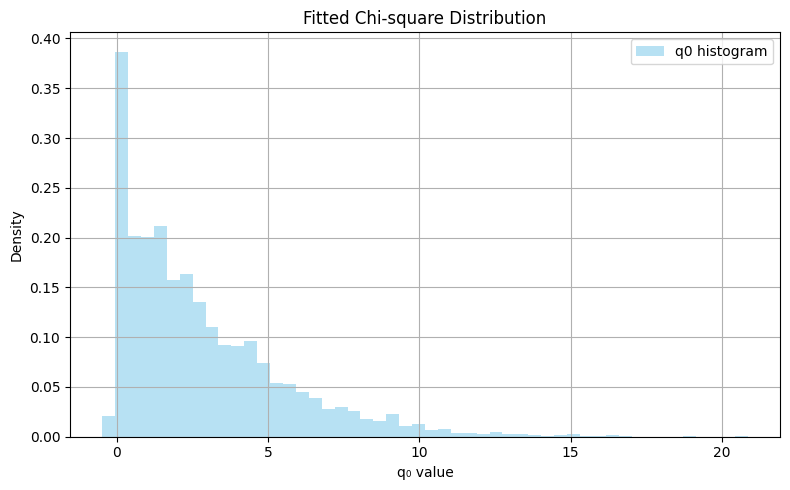

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Your actual q0_values array
# q0_values = np.array([...])

# Fit q0_values to a chi-square distribution
# This fits df, loc, scale unless you fix them
# fitted_params = chi2.fit(q0_values)
fitted_params = chi2.fit(q0_values)

df_fit, loc_fit, scale_fit = fitted_params
print(f"Fitted chi2 parameters: df = {df_fit:.3f}, loc = {loc_fit:.3f}, scale = {scale_fit:.3f}")

# Plot histogram
plt.figure(figsize=(8, 5))
counts, bins, _ = plt.hist(q0_values, bins=50, density=True, alpha=0.6, color='skyblue', label='q0 histogram')

# Plot fitted chi2 PDF
x = np.linspace(min(q0_values), max(q0_values), 500)
fitted_pdf = chi2.pdf(x, df_fit, loc=loc_fit, scale=scale_fit)
# plt.plot(x, fitted_pdf, 'r-', label=fr'Fitted $\chi^2$: df={df_fit:.2f}')
# plt.axvline(q0_obs, color='black', linestyle='--', linewidth=2, label=r'$q_{0}^{\mathrm{obs}}$')
#set x axis to log scale
# plt.xscale('log')


# Labels and legend
plt.xlabel('q₀ value')
plt.ylabel('Density')
plt.title('Fitted Chi-square Distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [10]:
q0_obs

263.33067118529107

In [11]:
# find if there any value of q0 in q0_values that is greater than q0_obs
q0_values[q0_values > q0_obs]

array([], dtype=float64)